1) Setup paths

In [15]:
import pandas as pd
from pathlib import Path

RAW = Path("../data/raw")
PROC = Path("../data/processed")
PROC.mkdir(parents=True, exist_ok=True)

COUNTRY_CODE = "KOR"

2) Load & reshape Fertility (World Bank)

In [16]:
# Try the common WB format (skip the 4-line header)
fert_raw = pd.read_csv(RAW / "KOR_fertility_raw.csv", skiprows=4)

# If you accidentally saved a single-country slice with no header rows,
# the following line won’t hurt; we’ll still filter by code when present.
if "Country Code" in fert_raw.columns:
    fert_kr = fert_raw[fert_raw["Country Code"] == COUNTRY_CODE].copy()
else:
    # Fallback: keep the whole frame (already country-only)
    fert_kr = fert_raw.copy()

# Drop non-year metadata columns if present
for col in ["Country Name","Country Code","Indicator Name","Indicator Code"]:
    if col in fert_kr.columns:
        fert_kr = fert_kr.drop(columns=col)

# Wide -> long: years to rows
fert_kr = fert_kr.melt(var_name="year", value_name="fertility").dropna()
fert_kr["year"] = fert_kr["year"].astype(int)

print(fert_kr.head(), fert_kr.tail(), fert_kr.shape)

# ... your fertility loading/reshaping code above ...
# fert_kr has columns: year, fertility
fert = fert_kr[["year", "fertility"]].copy()   # <-- add this line
print("fert:", fert.shape, fert.columns.tolist())

   year  fertility
0  1960      5.994
1  1961      5.803
2  1962      5.562
3  1963      5.334
4  1964      5.068     year  fertility
59  2019      0.918
60  2020      0.837
61  2021      0.808
62  2022      0.778
63  2023      0.721 (64, 2)
fert: (64, 2) ['year', 'fertility']


3) Load & reshape Marriage rate (OWID)

In [18]:
import pandas as pd

mar = pd.read_csv(RAW / "KOR_marriage_rate_raw.csv")

# If multiple countries are present, keep KOR only (safe even if already filtered)
if "Code" in mar.columns:
    mar = mar[mar["Code"] == COUNTRY_CODE].copy()

# Normalize column names to what we expect
mar = mar.rename(columns={
    "Year": "year",
    "Crude marriage rate (marriages per 1,000 people)": "marriage_rate",
    "marriage-rate-per-1000-inhabitants": "marriage_rate"  # alternative OWID header
})

# Validate presence
expected_cols = ["year", "marriage_rate"]
missing = [c for c in expected_cols if c not in mar.columns]
if missing:
    raise ValueError(
        f"Marriage CSV missing expected columns: {missing}\nColumns present: {mar.columns.tolist()}"
    )

# Keep, coerce types, drop NAs
mar = mar[expected_cols].copy()
mar["year"] = pd.to_numeric(mar["year"], errors="coerce").astype("Int64")
mar["marriage_rate"] = pd.to_numeric(mar["marriage_rate"], errors="coerce")
mar = mar.dropna(subset=["year", "marriage_rate"]).astype({"year": int}).reset_index(drop=True)

print(mar.head(), mar.tail(), mar.shape)

   year  marriage_rate
0  1970            9.2
1  1971            7.3
2  1972            7.3
3  1973            7.6
4  1974            7.5     year  marriage_rate
46  2016            5.5
47  2017            5.2
48  2018            5.0
49  2019            4.7
50  2020            4.2 (51, 2)


4) Align years to the overlap (1970–2020) and save processed files

In [19]:
# Align years 1970–2020 for Korea
START, END = 1970, 2020

# Fertility (should already be in tidy form: year, fertility)
fert = fert[(fert["year"] >= START) & (fert["year"] <= END)].copy()

# Marriage (now clean: year, marriage_rate)
mar = mar[(mar["year"] >= START) & (mar["year"] <= END)].copy()

# Merge on year
aligned = pd.merge(fert, mar, on="year", how="inner")

# Save outputs
fert.to_csv(PROC / "KOR_fertility.csv", index=False)
mar.to_csv(PROC / "KOR_marriage_rate.csv", index=False)
aligned.to_csv(PROC / "KOR_aligned.csv", index=False)

print("Saved:", list(PROC.glob("KOR_*.csv")))
print("Aligned shape:", aligned.shape)
print(aligned.head())
print(aligned.tail())

Saved: [PosixPath('../data/processed/KOR_aligned.csv'), PosixPath('../data/processed/KOR_marriage_rate.csv'), PosixPath('../data/processed/KOR_fertility.csv')]
Aligned shape: (51, 3)
   year  fertility  marriage_rate
0  1970       4.53            9.2
1  1971       4.54            7.3
2  1972       4.12            7.3
3  1973       4.07            7.6
4  1974       3.77            7.5
    year  fertility  marriage_rate
46  2016      1.172            5.5
47  2017      1.052            5.2
48  2018      0.977            5.0
49  2019      0.918            4.7
50  2020      0.837            4.2


5) (Optional) Quick visual sanity check

In [21]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(Path("../data/processed/KOR_aligned.csv"))
df.head()

,year,fertility,marriage_rate
0,1970,4.53,9.2
1,1971,4.54,7.3
2,1972,4.12,7.3
3,1973,4.07,7.6
4,1974,3.77,7.5


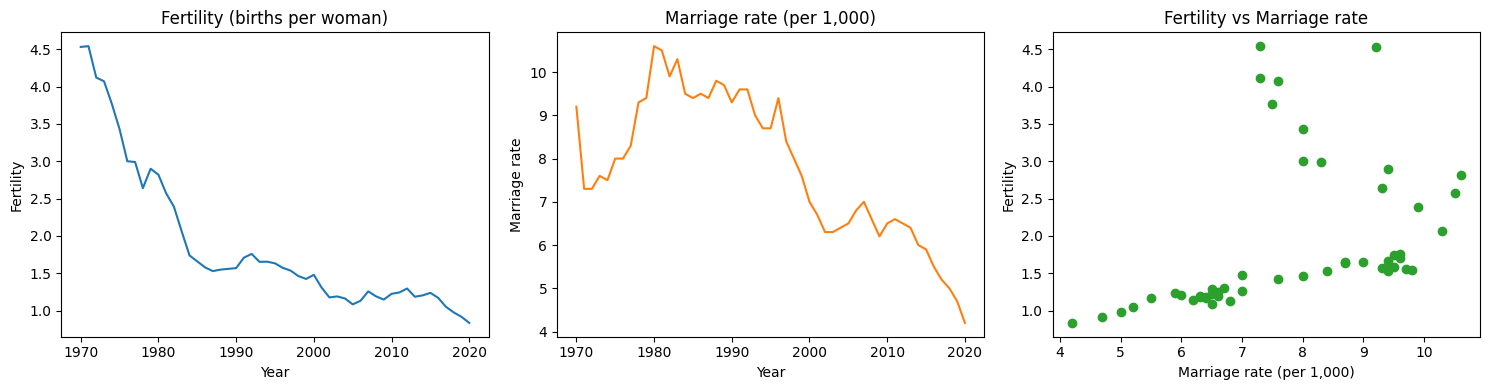

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Fertility over time
axes[0].plot(df["year"], df["fertility"], color="tab:blue")
axes[0].set_title("Fertility (births per woman)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Fertility")

# Marriage rate over time
axes[1].plot(df["year"], df["marriage_rate"], color="tab:orange")
axes[1].set_title("Marriage rate (per 1,000)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Marriage rate")

# Scatter plot (correlation)
axes[2].scatter(df["marriage_rate"], df["fertility"], color="tab:green")
axes[2].set_title("Fertility vs Marriage rate")
axes[2].set_xlabel("Marriage rate (per 1,000)")
axes[2].set_ylabel("Fertility")

plt.tight_layout()
plt.show()

Compute the Pearson correlation coefficient

In [24]:
corr = df["fertility"].corr(df["marriage_rate"])
print(f"Correlation (fertility vs marriage rate): {corr:.3f}")

Correlation (fertility vs marriage rate): 0.392
